In [64]:
import pandas as pd
import numpy as np
import json
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
from random import sample
from datetime import datetime
from nltk.corpus import stopwords
from string import punctuation
from zipfile import ZipFile
import seaborn as sns
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

#### we have tweets downloaded in a file where every line is a separate tweet
#### the files are in a zip for smaller storage. first we read the tweets into a list

In [99]:
tweets=[]
with ZipFile('tweets_tsla_en.zip') as z:
    with z.open('tweets_tsla_en.txt') as input_file:
        for line in input_file:
            tweets.append(json.loads(line))
print(len(tweets))

18171


#### load the data into a pandas dataframe. we take in full_text, user id, followers count, user description and retweet count

In [100]:
tweet_df=pd.DataFrame({
    'ts':[datetime.strptime(t['created_at'],'%a %b %d %H:%M:%S %z %Y') for t in tweets],
    'text':[t['full_text'] for t in tweets],
    'uid':[str(t['user']['id']) for t in tweets],
    'followers':[t['user']['followers_count'] for t in tweets],
    'user_description':[t['user']['description'] for t in tweets],
    'retweets':[t['retweet_count'] for t in tweets],
})
tweet_text=tweet_df['text'].tolist()
del tweets
print(tweet_df.shape)
tweet_df.sample(10)

(18171, 6)


,ts,text,uid,followers,user_description,retweets
1146,2019-03-23 14:19:51+00:00,"@fly4dat @bgrahamdisciple Yes, it would seem t...",1023266600223481856,2459,"Quite sure the stock boom will never end, and ...",1
1716,2019-03-22 23:05:03+00:00,$KRW Gives you hope for humanity when you see ...,717829870563164161,519,Cannabis Stocks Enthusiast 📈📉,0
12020,2019-03-18 16:01:13+00:00,@boriquagato $TSLA well you clearly don't know...,4438537155,75,"Engineer/MBA, part time trader, full time Spa...",0
13892,2019-03-17 05:00:59+00:00,Pier 80 Today®. \n\nDone.\n\n$tslaQ $TSLA http...,1005530743,2862,Tesla can stay insolvent longer than you can s...,19
7942,2019-03-20 01:31:39+00:00,@Tslareaper Responding: TSLA limits officers ...,1087072895610904576,32,,0
6540,2019-03-20 19:16:05+00:00,@HyperChangeTV Just watched. \n\nQuestion: Do ...,10832732,392,"RIA, product manager, programmer. Tweets are n...",0
4012,2019-03-21 22:31:26+00:00,"""Guys , look , please put in all you can , 80 ...",920833801,826,I'm aware that I'm living in a bubble.,0
13217,2019-03-17 19:34:54+00:00,@ElonsTruths While ROIC does not matter for TS...,1034853118746476544,7,CFA. Every man I meet in some way is my superi...,0
17045,2019-03-15 15:03:38+00:00,Tesla sinks after analysts were underwhelmed b...,940765422,220,,0
3534,2019-03-22 02:54:32+00:00,@PJalihal @048_and @marchmadness So what you'r...,966487357385052160,4,"Use my referral for 1,000 miles free Superchar...",0


In [95]:
tweet_df['ts'].max()

Timestamp('2019-03-24 16:13:15+0000', tz='UTC')

#### for the tweets, extract tokens

In [81]:
stop_words=list(set(stopwords.words('english')))
for item in punctuation:
    stop_words.append(item)
    
def my_tokenizer(in_string):
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    lemmatizer = WordNetLemmatizer()
    tweets = lemmatizer.lemmatize(in_string)
    in_string=in_string.replace("$","#_")
    tokens = tokenizer.tokenize(in_string)
    return_tokens=[]
    for token in tokens:
        if 'http://' not in token and 'https://' not in token and 'tsla' not in token: return_tokens.append(token.replace("#_","$"))
    return return_tokens

def remove_http(in_string):
    words=in_string.split(" ")
    return ' '.join(w for w in words if 'http' not in w)

#### combine all the tokens. we already have elon and musk so we remove the word elonmusk (i guess he gets tagged a lot)

In [53]:
all_tokens=[]
for text in tweet_text:
    temp_list=my_tokenizer(text)
    for item in temp_list:
        if item not in stop_words and 'elonmusk' not in item:
            all_tokens.append(item)
print(len(all_tokens))

278625


#### generate a wordcloud

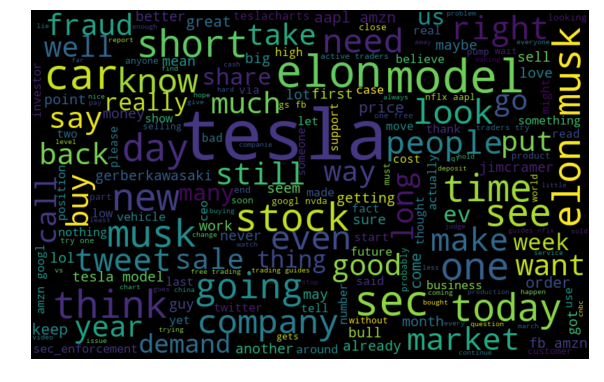

In [62]:
all_words = ' '.join([text for text in all_tokens])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### function for sentiment analysis

In [74]:
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score

In [139]:
i=9999
print(tweet_text[i])
sTemp=remove_http(tweet_text[i])
print(sTemp)
zz=sentiment_analyzer_scores(sTemp)
print(zz)

Tesla (TSLA:NAS) and China Unicom (CHU:NYS) Upgraded https://t.co/QTLmRwetLp https://t.co/ywBqV1YmVm
Tesla (TSLA:NAS) and China Unicom (CHU:NYS) Upgraded
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


#### use TfIdf to convert tweet text into 

In [8]:
vec=TfidfVectorizer(tokenizer=my_tokenizer,stop_words=stop_words,max_features=1000)
matrix=vec.fit_transform(tweet_text)
matrix

<18171x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 152833 stored elements in Compressed Sparse Row format>

#### randonly sample some of the tfidf columns

In [9]:
(pd.DataFrame(matrix[:10].todense(),columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,330:430])

,course,court,cover,cramer,crash,crazy,credit,criminal,cult,current,...,fast,feel,file,filing,finally,financial,find,fine,fire,first
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.371254,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Elbow method for Kmeans

fitting model for 2 clusters
fitting model for 50 clusters
fitting model for 200 clusters
fitting model for 500 clusters


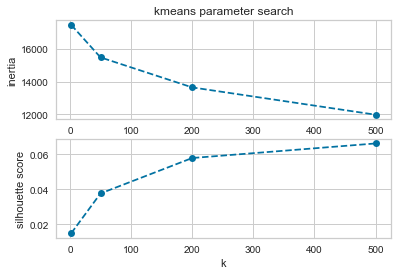

In [10]:
# compare a broad range of ks to start
ks = [2, 50, 200, 500]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1)
    model.fit(matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

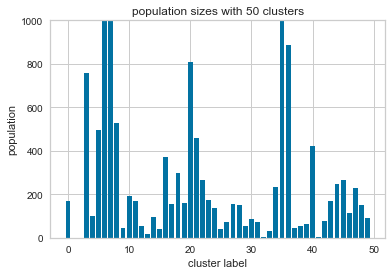

In [140]:
best_k = 50

km_model = KMeans(n_clusters=best_k, n_jobs=-1)
km_model.fit(matrix)

plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

In [141]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [142]:
strongest_features(km_model, vec, topk=15)

Cluster 0: looks like ... model new 3 ’ tesla see going good look suv time week
Cluster 1: investor @vincent13031925 @s_padival important interesting fact getting twitter shares news @jimcramer 1 musk elon @elonmusk
Cluster 2: manipulation board ️ point please make @tesla stock @elonmusk credit crazy couple criminal cult crash
Cluster 3: ... @elonmusk elon tesla ’ @tesla going good model really today day think #tesla still
Cluster 4: $dia $spy $ndx $iwm $fb $tlt $vix $qqq $spx $gld $msft $eem $slv $nflx $amzn
Cluster 5: “ ” ’ tesla elon ... like model musk rating car sec #tesla @elonmusk 3
Cluster 6: ’ @elonmusk tesla elon ‘ musk stock #tesla sec time let going think today @tesla
Cluster 7: @elonmusk #tesla @tesla stock time today would going cars short car company see day get
Cluster 8: like used stock tesla's trade ... would @elonmusk look car see ’ seems tesla @tesla
Cluster 9: tweeted check top $cgc 10 big $twtr $snap $ba $amd morning $ulta $fb $mu $acb
Cluster 10: shares tesla buy

In [143]:
tsne = TSNE(n_components=2)
matrix_2d = tsne.fit_transform(matrix.todense())

In [148]:
def get_plottable_df( retweets,text, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart.

    Note: assumes that all argument data series
    are in the same order e.g. the first user, bio, coords, and label
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    # combine data into a single df
    df = pd.DataFrame({'text': text,
                       'retweets': retweets,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1],
                      })
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

In [149]:
# pass in the cluster assignments from the kmeans model
km_plottable_bios=get_plottable_df(tweet_df['retweets'].tolist(),tweet_df['text'].tolist(), matrix_2d, km_model.labels_)
km_plottable_bios.head()

,text,retweets,label,x_val,y_val,color
0,I guess this is why #Tesla doesn't pay to adve...,0,3,8.265903,34.343311,#db8e57
1,@SnazzyQ I wouldn't hate $tsla if they didn't ...,0,34,-48.106823,0.094623,#6957db
2,https://t.co/s6lVxNDe7C &lt; My Review of The ...,0,40,-66.281662,-11.676118,#c957db
3,@anonyx10 @jasonsbishop @lexfridman He also ta...,0,7,1.572584,55.260086,#dbce57
4,Careful @elonmusk the @SEC_News might file an...,0,7,-11.942537,-42.468750,#dbce57


In [150]:
def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""")
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val',
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

In [152]:
show(plot_tsne(km_plottable_bios.sample(5000),'t-sne projection of kmeans-clustered users ["(cluster #) bio"]'))

In [105]:
temp_df=tweet_df[['followers','retweets']].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(temp_df)
transformed_data=scaler.transform(temp_df)

c:\users\tihor\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\tihor\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


array([[-0.13862182, -0.06026823],
       [-0.14051269, -0.06026823],
       [-0.13795214, -0.06026823],
       ...,
       [-0.13314618, -0.06026823],
       [-0.04884499, -0.06026823],
       [-0.13432797, -0.06026823]])

fitting model for 30 clusters
fitting model for 40 clusters
fitting model for 50 clusters
fitting model for 60 clusters
fitting model for 70 clusters
fitting model for 80 clusters


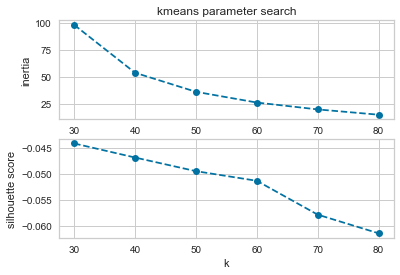

In [108]:
# compare a broad range of ks to start
ks = [30,40, 50, 60, 70,80]

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1)
    model.fit(transformed_data)
    labels = model.labels_
    sil_scores.append(silhouette_score(matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

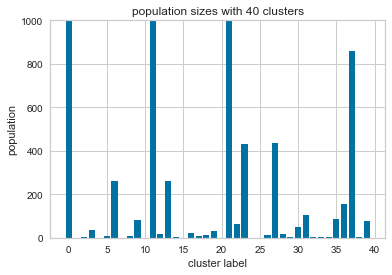

In [110]:
best_k = 40

km_model = KMeans(n_clusters=best_k, n_jobs=-1)
km_model.fit(transformed_data)

plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

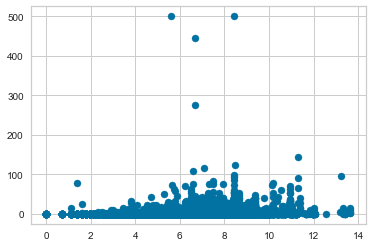

In [128]:
plt.scatter(tweet_df['followers'].apply(lambda x:np.log(x)),tweet_df['retweets'].apply(lambda x:x if x<500 else 500), s=50);

In [124]:
zz=tweet_df[tweet_df['retweets']>1000]
)

,ts,text,uid,followers,user_description,retweets
13069,2019-03-17 21:52:49+00:00,"People are buying Tesla’s, in their Tesla’s. ...",22400492,273,"Geek, British, elitist shape thrower. Amateur ...",2928
